
    Title: Spatio Temporal Clustering
    Author: Benseguane Abderrahim
    Date: 23/03/2020
    Code version: 0
    Kaggle team: Data Solution
    Company: ENGIE IT

### Spatio-temporal feature extraction

#### Unsuppervised learning approach

Note: It was hard for me to install gdal and arcpy in this kernel, inside Kaggle, so please take time to install these packages like you can.
Also be careful about paths to files, and all should work fine.

Intro:

This challenge introduced me to geoprocessing, and Raster file format. Now it became apparent to me that Raster files are really to be treated so! It is not just a 2D image. 

For example:
A raster image is an image file format that is defined by a pixel that has one or more numbers associated with it.
It has environment variables, like Extent, Origin, .. 
(see https://desktop.arcgis.com/fr/arcmap/10.3/manage-data/raster-and-images/what-is-raster-data.htm)

As a result, clustering analysis, missing values imputations, and many other analysis, need to take these into consideration. 
Hopefully, there are people specilized in these, and the open source community if full of easy and sophisticated tools.

Here I tried to use QGis and ArcGis Pro (see http://arcgis.com) to ease exploration, but most importantly to export commands and run then from Python on all files (batch mode like). 
Most QGis processing routine call GDAL python library (see https://www.osgeo.org/) and also some arcgis tools are also documented giving there equivalent arcpy code (see https://pro.arcgis.com/en/pro-app/arcpy/get-started/what-is-arcpy-.htm)


In [ ]:
import glob, os
import gdal
from arcpy import env
from arcpy.sa import *
from arcpy import RasterToNumPyArray
import numpy as np

for file in glob.glob("*.tif"):
    print(file)
    break

Lets count nan values in our fils

In [ ]:
np.count_nonzero(np.isnan(RasterToNumPyArray(Raster('s5p_no2_20180917T164548_20180923T182508.tif'))))

In [ ]:
np.count_nonzero(np.isnan(RasterToNumPyArray(Raster('20180917T164548_20180923T182508.tif.tiff'))))

Lets see if there are different extent coordinates

In [ ]:


full_files = []
extents = []

one_extent = '{"xmin":-67.324313912888414,"ymin":17.90015055109518,"xmax":-65.190815113104549,"ymax":18.564903861343627,"spatialReference":{"wkid":4326,"latestWkid":4326}}'
for file in glob.glob("NODATA/*.tiff"):  
    outraster0 = Raster(file)
    arr0 = RasterToNumPyArray(outraster0)
    extents.append(outraster0.extent.JSON)
    if(np.count_nonzero(np.isnan(arr0))==0):
        full_files.append(file[7:])

In [ ]:
list(set(extents))

Let's unify extents

In [ ]:
one_extent = '{"xmin":-67.324313912888414,"ymin":17.90015055109518,"xmax":-65.190815113104549,"ymax":18.564903861343627,"spatialReference":{"wkid":4326,"latestWkid":4326}}'
for file in glob.glob("NODATA/*.tiff"):
    filename = os.path.basename(file)[8:]
    ds = gdal.Translate("NODATA_NORM/"+filename, file, projWin = [-67.32, 17.90, -65.19, 18.56])
    if ds is None:
        print(file + ' failed')

In [ ]:
outraster0.extent.JSON

#### Translate .tif to .vrt, extracting bands to different folders 
##### With gdal.Translate

We can export files to there specific separate bands in different files

In [ ]:
# AttributeError: 'NoneType' object has no attribute 'GetMaskBand'

In [ ]:
# This saves bands to individual files


from osgeo import gdal


for i in range(12):
    os.mkdir("output_multibands/band_"+str(i+1))

for file in glob.glob("*.tif"):
    in_path = file  #input composite raster
    out_path = 'output_multibands/' #output directory for individual bands as files

    #Open existing raster ds
    src_ds = gdal.Open(in_path)

    for i in range(1,src_ds.RasterCount +1): #Save bands as individual files
        out_ds = gdal.Translate(out_path + '/band_' + str(i) + "/" + file.split('.')[0]+".vrt", src_ds, format='VRT', bandList=[i])
        out_ds=None
        


I will be running gdal routines using subprocess#check_output

In [ ]:
["\"C:/Program Files/QGIS 3.12/bin/python3.exe\"","\"C:/Program Files/QGIS 3.12/apps/Python37/Scripts/gdal_fillnodata.py\"", "-md ", " 10 ", " -b ", " 4 ", "-of", "GTiff", "C:/Users/HR5537/Downloads/ds4g-environmental-insights-explorer/eie_data/s5p_no2/s5p_no2_20190629T174803_20190705T194117.tif", "C:/Users/HR5537/Downloads/ds4g-environmental-insights-explorer/eie_data/s5p_no2/OUTPUT4.tif"]

In [ ]:
"\"C:/Program Files/QGIS 3.12/bin/python3.exe\" \"C:/Program Files/QGIS 3.12/apps/Python37/Scripts/gdal_fillnodata.py\" -md 10 -b 4 -of GTiff  C:/Users/HR5537/Downloads/ds4g-environmental-insights-explorer/eie_data/s5p_no2/s5p_no2_20190629T174803_20190705T194117.tif OUTPUT10.tif"

In [ ]:
# "\"C:\Program Files\QGIS 3.12\bin\python3.exe\" \"C:\Program Files\QGIS 3.12\apps\Python37\Scripts\gdal_fillnodata.py\" -md 10 -b 4 -of GTiff  s5p_no2_20180705T163817_20180712T105412.tif OUTPUT.tif

#### Add nodata value to rasters tif 
##### with gdalwarp

In [ ]:
# Risky: shell commands from python.
from subprocess import check_output


In [ ]:
# let's analyse by one band at a time,
# taking first band here
# Note even when not tif original file is not specified in input, 
# it must be there with the vrt file (for some reason. I don't know why)


for file in glob.glob("*.vrt"):
    check_output("gdalwarp "+file+" "+file.split('.')[0]+"_warp.tif -dstnodata -9999", shell=True)

Separatly, we can approximate NODATA points using gdal_fillnodata 

The following command is to be run in Windows Bash, I could not use subprocess#check_output to run it for some reason. 

FOR %i IN (C:\Users\HR5537\Downloads\ds4g-environmental-insights-explorer\eie_data\s5p_no2\NODATA\\*.tif) DO "C:/Program Files/QGIS 3.12/bin/python3.exe" "C:/Program Files/QGIS 3.12/apps/Python37/Scripts/gdal_fillnodata.py" -md 10 -b 4 -of GTiff  "%i" "%i.tif2"

FOR %i IN (C:\Users\HR5537\Downloads\ds4g-environmental-insights-explorer\eie_data\s5p_no2\NODATA\\*.tif) DO "C:/Program Files/QGIS 3.12/bin/python3.exe" "C:/Program Files/QGIS 3.12/apps/Python37/Scripts/gdal_fillnodata.py" -md 10 -b 4 -of GTiff  "%i" "%i.tiff"

### Calculate spatial signature on out time-serie satellite images
##### Using: gpat_gridts 

Let's build gpat_gridts commands
part of GeoPAT2 (see https://usermanual.wiki/Pdf/GeoPAT2Manual.703444930/)

In [ ]:
import glob

input_builder = []
os.chdir("NODATA_NORM")

for file in glob.glob("*.tiff"): #NODATA_NORM/*.tiff
    input_builder.append(os.path.basename(file))
inputs = np.array_split(input_builder, 12)
inputs = [" -i " + " -i ".join(input) for input in inputs]
commands = ["gpat_gridts "+input+" -o spatiotemporalgrid -n" for input in inputs]
# check_output("gpat_gridts "+input_files+" -o spatiotemporalgrid -n", shell=True)


In [ ]:
check_output("gpat_gridts -i s5p_no2_20190612T162549_20190618T180057_warp.tif -i s5p_no2_20190613T160647_20190619T174418_warp.tif -i s5p_no2_20190613T174817_20190619T193125_warp.tif -i s5p_no2_20190614T172915_20190620T191204_warp.tif -i s5p_no2_20190616T165111_20190622T183247_warp.tif -i s5p_no2_20190617T163209_20190623T182116_warp.tif -i s5p_no2_20190618T161307_20190624T180620_warp.tif -i s5p_no2_20190619T173534_20190625T192848_warp.tif -i s5p_no2_20190620T171632_20190626T190833_warp.tif -i s5p_no2_20190621T165729_20190627T185343_warp.tif -i s5p_no2_20190622T163826_20190628T181049_warp.tif -i s5p_no2_20190623T161923_20190629T180700_warp.tif -i s5p_no2_20190624T160021_20190630T174143_warp.tif -i s5p_no2_20190624T174150_20190630T192108_warp.tif -i s5p_no2_20190625T172247_20190701T190612_warp.tif -i s5p_no2_20190626T170344_20190703T114437_warp.tif -i s5p_no2_20190627T164441_20190703T183146_warp.tif -i s5p_no2_20190628T162537_20190704T180917_warp.tif -i s5p_no2_20190629T160634_20190705T174521_warp.tif -i s5p_no2_20190629T174803_20190705T194117_warp.tif -o spatiotemporalgrid -n", shell=True)

The gotcha here, is that gpat_gridts is very sensible to missing values, and different environment values in input files, so 
to make it work, we better unify files (impute NODATA, unify extents...)
Also, I think gpat_gridts cannot catch long list of files for some reason. so we can iterately run on time oredered batch of files and get clustering results from each, then finally average clustering results. 

In [ ]:
commands[1]

In [ ]:
check_output(commands[1], shell=True)


#### latlon.csv is the list of geo-points to find very similar temporal patterns of a NO2 (NO2_column_number_density).    

In [ ]:
# df_power_plants = pd.read_csv('gppd_120_pr.csv')
# import json

# def string_to_dict(dict_string):
#     # Convert to proper json format (from here: https://stackoverflow.com/questions/39169718/convert-string-to-dict-then-access-keyvalues-how-to-access-data-in-a-class)
#     dict_string = dict_string.replace("'", '"').replace('u"', '"')
#     return json.loads(dict_string)['coordinates']

# df_power_plants['coord'] = df_power_plants['.geo'].apply(string_to_dict)
# pd.DataFrame(df_power_plants['coord'].values.tolist()).to_csv('latlon.csv', index=False)

In [ ]:
os.chdir("NODATA_NORM")

In [ ]:
check_output("gpat_pointsts -i spatiotemporalgrid -o stpoints --xy_file=latlon.csv", shell=True)

In [ ]:
check_output("gpat_distmtx -i stpoints -o result.csv -m tsEUC", shell=True)

#### Plot!

In [ ]:
# install.packages("mapproj")
# library(sf)
# library(tmap)
# library(tigris)
# library(rgeopat2)
# library(mapproj)

# distmatrix = gpat_read_distmtx("result.csv")
# hclust_result = hclust(d = distmatrix, method = "ward.D2")
# plot(hclust_result, labels = FALSE)
# sel_points = read.csv("latlon.csv", header = FALSE)
# sel_points$class = as.factor(cutree(hclust_result, k = 4))
# sel_points_st = st_as_sf(sel_points, coords = c("V1", "V2"))


# me = counties("PR", cb = TRUE).
# tm_shape(me) + tm_borders(alpha=0.5) + tm_shape(sel_points_st) + tm_dots(col = "class", size = 0.25, title = "Class: ")

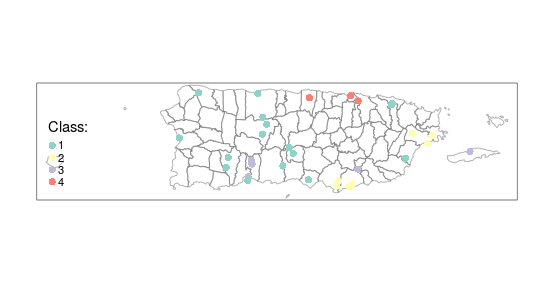

##### Build a z-axis and visualize

In [ ]:
# > library(raster)
# > library(rasterVis)
# > listFich <- dir(pattern='\\.tiff')
# > stackSIS <- stack(listFich)
# > idx <- seq(as.Date('2008-07-14'), as.Date('2008-07-17'), 'day')
# > SISmm <- setZ(stackSIS, idx)
# > names(SISmm) <- c('07/14','07/15','07/16','07/18')
# > levelplot(SISmm)

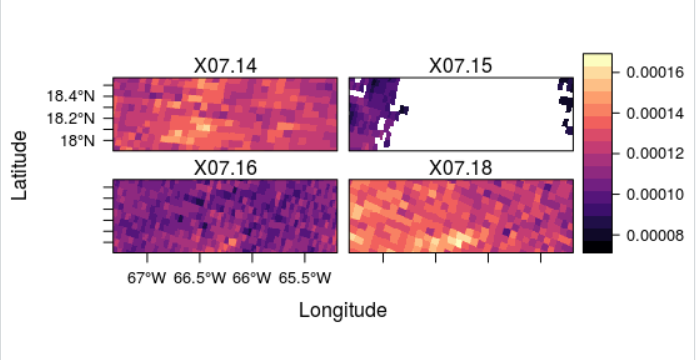

Alternatives !!
Apparently, there are many studies in the academia, about spatio-temporal clustering, in most cases I found, it is about clustering a set of datapoints dispersed on a single map area, and polygons need to be present in the map and not for clustering all values without boundaries. Nevertheless, here I share all, to gain perspectives and hopefully other perspectives.

https://github.com/Kersauson/ST-DBSCAN
https://tslearn.readthedocs.io/en/latest/gen_modules/clustering/tslearn.clustering.TimeSeriesKMeans.html

z-axis (time):
https://en.wikipedia.org/wiki/Hovm%C3%B6ller_diagram
https://informatique-mia.inra.fr/resste/sites/informatique-mia.inra.fr.resste/files/analyzing-spatio-temporal.pdf
https://oscarperpinan.github.io/rastervis/
